In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#https://github.com/nikhilroxtomar/UNet-Segmentation-in-Keras-TensorFlow/blob/master/unet-segmentation.ipynb
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Seeding
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [ ]:
image_size=128

In [ ]:

image_path='/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Nucleus-Segmentation/images_normalised'
groundtruth_path='/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Nucleus-Segmentation/groundtruth'

In [ ]:
img_id=[]
for image in os.listdir(image_path):
  img_id.append(image)
  #print(img_id)
img_id.sort()
print(img_id)

['01_1.png', '01_2.png', '01_3.png', '01_4.png', '01_5.png', '01_6.png', '01_7.png', '02_1.png', '02_2.png', '02_3.png', '03_1.png', '03_2.png', '03_3.png', '03_4.png', '03_5.png', '04_1.png', '04_2.png', '04_3.png', '04_4.png', '04_5.png', '04_6.png', '04_7.png', '04_8.png', '05_1.png', '05_2.png', '05_3.png', '05_4.png', '06_1.png', '06_2.png', '06_3.png', '07_1.png', '07_2.png', '07_3.png', '08_1.png', '08_2.png', '08_3.png', '08_4.png', '09_1.png', '09_2.png', '09_3.png', '09_4.png', '09_5.png', '09_6.png', '10_1.png', '10_2.png', '10_3.png', '10_4.png', '11_1.png', '11_2.png', '11_3.png']


In [ ]:
for img in img_id:
  path=image_path+'/'+img
  print(path)

/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Nucleus-Segmentation/images_normalised/01_1.png
/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Nucleus-Segmentation/images_normalised/01_2.png
/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Nucleus-Segmentation/images_normalised/01_3.png
/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Nucleus-Segmentation/images_normalised/01_4.png
/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Nucleus-Segmentation/images_normalised/01_5.png
/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Nucleus-Segmentation/images_normalised/01_6.png
/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Nucleus-Segmentation/images_normalised/01_7.png
/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Nucleus-Segmentation/images_normalised/02_1.png
/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Nucleus-Segmentation/images_normalised/02_2.png
/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Nucleus-

In [ ]:
mask_id=[]
for mask in os.listdir(groundtruth_path):
  mask_id.append(mask)
  #print(img_id)
mask_id.sort()
print(mask_id)

['01_1.png', '01_2.png', '01_3.png', '01_4.png', '01_5.png', '01_6.png', '01_7.png', '02_1.png', '02_2.png', '02_3.png', '03_1.png', '03_2.png', '03_3.png', '03_4.png', '03_5.png', '04_1.png', '04_2.png', '04_3.png', '04_4.png', '04_5.png', '04_6.png', '04_7.png', '04_8.png', '05_1.png', '05_2.png', '05_3.png', '05_4.png', '06_1.png', '06_2.png', '06_3.png', '07_1.png', '07_2.png', '07_3.png', '08_1.png', '08_2.png', '08_3.png', '08_4.png', '09_1.png', '09_2.png', '09_3.png', '09_4.png', '09_5.png', '09_6.png', '10_1.png', '10_2.png', '10_3.png', '10_4.png', '11_1.png', '11_2.png', '11_3.png']


In [ ]:
from PIL import Image

In [ ]:
used_ids=[]

In [ ]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, batch_size=8, image_size=128):
        self.ids = ids
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()

    def __load__(self, id_name):
        ## Path
        image_path ='/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Nucleus-Segmentation/images_normalised'+'/'+id_name
        mask_path = '/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Nucleus-Segmentation/groundtruth'+'/'+id_name


        ## Reading Image

        image = cv2.imread(image_path, 1)


        mask = cv2.imread(mask_path, 0)
        if(image is None or mask is None):
          print("Error: ",id_name)
        image = cv2.resize(image, (self.image_size, self.image_size))
        mask = cv2.resize(mask, (self.image_size, self.image_size))




        ## Normalizaing
        mask[mask>0]=255
        #print(np.unique(mask))
        image = image/255.0
        mask = mask/255.0

        #print(np.unique(mask))
        return image, mask

    def __getitem__(self, index):
        # if(index+1)*self.batch_size > len(self.ids):
        #     self.batch_size = len(self.ids) - index*self.batch_size

        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        print(len(files_batch))
        if(len(files_batch)<self.batch_size):
          files_batch.extend(self.ids[0:self.batch_size-len(files_batch)])
        image = []
        mask  = []

        for i,id_name in enumerate(files_batch):
            while(not id_name.split('.')[1]=='png'):
              id_name=files_batch[i+1]
              i+=1
              if(i>=self.batch_size):
                i=0
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)


        image = np.array(image)
        mask  = np.array(mask)

        return image, mask

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [ ]:
image_size = 128
epochs = 50
batch_size = 8

## Training Ids
train_ids = img_id

## Validation Data Size
val_data_size = 10

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

In [ ]:
print(valid_ids)

['01_1.png', '01_2.png', '01_3.png', '01_4.png', '01_5.png', '01_6.png', '01_7.png', '02_1.png', '02_2.png', '02_3.png']


In [ ]:

gen = DataGen(train_ids, batch_size=batch_size, image_size=image_size)
for x,y in gen:
  print(x.shape)

8
(8, 128, 128, 3)
8
(8, 128, 128, 3)
8
(8, 128, 128, 3)
8
(8, 128, 128, 3)
8
(8, 128, 128, 3)


In [ ]:
gen = DataGen(train_ids, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
# y_copy=y.copy()
print(x.shape, y.shape)

8
(8, 128, 128, 3) (8, 128, 128)


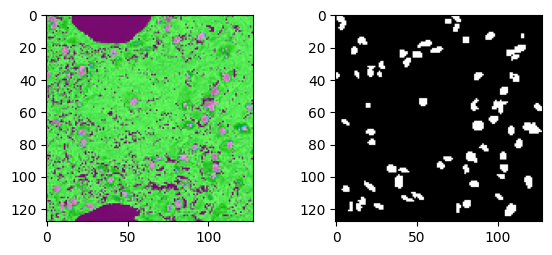

In [ ]:
# r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[0])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[0], (image_size, image_size)), cmap="gray")

In [ ]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [ ]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))

    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8

    bn = bottleneck(p4, f[4])

    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128

    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [ ]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

#50 epoch result

In [ ]:
train_gen = DataGen(train_ids, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size
print(used_ids)
model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps,
                    epochs=epochs)
print(len(np.unique(used_ids)))
print(used_ids)

[]
8


<ipython-input-19-758a56b68243>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps,


Epoch 1/50
8
8
5/5 [==============================] - ETA: 0s - loss: 0.5739 - acc: 0.81828
8
2
5/5 [==============================] - 24s 4s/step - loss: 0.5739 - acc: 0.8182 - val_loss: 0.3617 - val_acc: 0.9048
Epoch 2/50
8
8
5/5 [==============================] - ETA: 0s - loss: 0.4815 - acc: 0.85548
2
5/5 [==============================] - 9s 2s/step - loss: 0.4815 - acc: 0.8554 - val_loss: 0.3833 - val_acc: 0.9048
Epoch 3/50
8
8
5/5 [==============================] - ETA: 0s - loss: 0.4491 - acc: 0.85548
2
5/5 [==============================] - 11s 2s/step - loss: 0.4491 - acc: 0.8554 - val_loss: 0.3205 - val_acc: 0.9048
Epoch 4/50
8
8
5/5 [==============================] - ETA: 0s - loss: 0.4457 - acc: 0.85548
2
5/5 [==============================] - 11s 2s/step - loss: 0.4457 - acc: 0.8554 - val_loss: 0.3292 - val_acc: 0.9048
Epoch 5/50
8
8
5/5 [==============================] - ETA: 0s - loss: 0.4383 - acc: 0.85548
2
5/5 [==============================] - 10s 2s/step - loss: 0.

In [ ]:
print(used_ids)

[]


In [ ]:
## Save the Weights
#model.save_weights("UNetW.h5")

## Dataset for prediction
x, y = valid_gen.__getitem__(1)
result = model.predict(x)

result = result > 0.3

2
1/1 [==============================] - 1s 582ms/step


In [ ]:
print(np.unique(result))

[False  True]


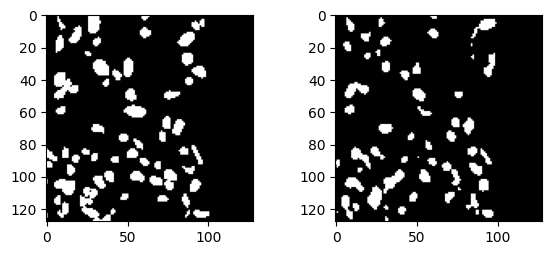

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size,1)), cmap="gray")

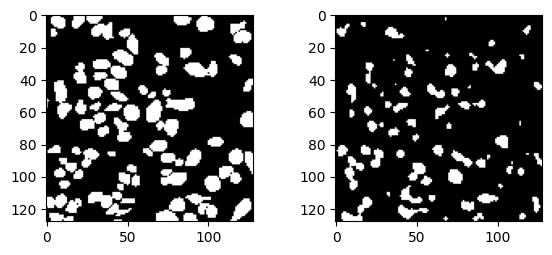

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size,1)), cmap="gray")

In [ ]:
model.save_weights('/content/drive/MyDrive/Hepatoma-Staging-Project/Weights/UnetW_50_normalised.h5')

In [ ]:
model.load_weights('/content/drive/MyDrive/Hepatoma-Staging-Project/Weights/UnetW_50_normalised.h5')

#100 epoch results


In [ ]:
train_gen = DataGen(train_ids, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size
print(used_ids)
model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps,
                    epochs=epochs)
print(len(np.unique(used_ids)))
print(used_ids)

[]
8


<ipython-input-27-758a56b68243>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps,


Epoch 1/50
8
8
5/5 [==============================] - ETA: 0s - loss: 0.2512 - acc: 0.90228
8
2
5/5 [==============================] - 10s 2s/step - loss: 0.2512 - acc: 0.9022 - val_loss: 0.1708 - val_acc: 0.9510
Epoch 2/50
8
8
5/5 [==============================] - ETA: 0s - loss: 0.2528 - acc: 0.90228
2
5/5 [==============================] - 9s 2s/step - loss: 0.2528 - acc: 0.9022 - val_loss: 0.1615 - val_acc: 0.9497
Epoch 3/50
8
8
5/5 [==============================] - ETA: 0s - loss: 0.2602 - acc: 0.89788
2
5/5 [==============================] - 11s 2s/step - loss: 0.2602 - acc: 0.8978 - val_loss: 0.1657 - val_acc: 0.9362
Epoch 4/50
8
8
5/5 [==============================] - ETA: 0s - loss: 0.2656 - acc: 0.89518
2
5/5 [==============================] - 11s 2s/step - loss: 0.2656 - acc: 0.8951 - val_loss: 0.1774 - val_acc: 0.9442
Epoch 5/50
8
8
5/5 [==============================] - ETA: 0s - loss: 0.2524 - acc: 0.90298
2
5/5 [==============================] - 9s 2s/step - loss: 0.2

In [ ]:
## Dataset for prediction
x, y = valid_gen.__getitem__(1)
result = model.predict(x)

result = result > 0.3

2
1/1 [==============================] - 0s 330ms/step


In [ ]:
print(x.shape)

(8, 128, 128, 3)


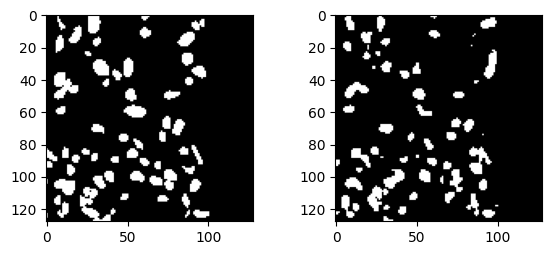

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size,1)), cmap="gray")

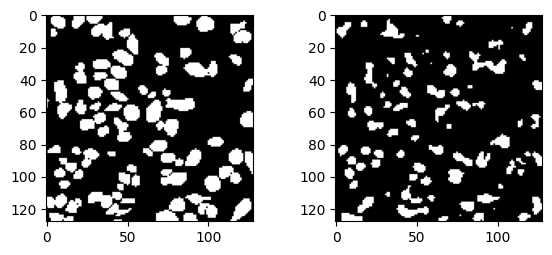

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size,1)), cmap="gray")

In [ ]:
model.save_weights('/content/drive/MyDrive/Hepatoma-Staging-Project/Weights/UnetW_100_normalised.h5')

#Model Predict and save Non_cancerous

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np

In [ ]:
image_path='/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Hepatoma-Stages-Dataset/ADASYN_normalised/Non_cancerous'

In [ ]:
img_id=[]
for image in os.listdir(image_path):
  img_id.append(image)
  #print(img_id)
img_id.sort()
print(img_id)
print(len(img_id))

['f10.jpeg', 'f102.jpeg', 'f106.jpeg', 'f107.jpeg', 'f108.jpeg', 'f11.jpeg', 'f110.jpeg', 'f111.jpeg', 'f112.jpeg', 'f113.jpeg', 'f117.jpeg', 'f118.jpeg', 'f121.jpeg', 'f123.jpeg', 'f125.jpeg', 'f133.jpeg', 'f134.jpeg', 'f137.jpeg', 'f138.jpeg', 'f140.jpeg', 'f148.jpeg', 'f15.jpeg', 'f150.jpeg', 'f151.jpeg', 'f153.jpeg', 'f154.jpeg', 'f158.jpeg', 'f16.jpeg', 'f167.jpeg', 'f17.jpeg', 'f171.jpeg', 'f180.jpeg', 'f181.jpeg', 'f185.jpeg', 'f188.jpeg', 'f19.jpeg', 'f190.jpeg', 'f191.jpeg', 'f192.jpeg', 'f194.jpeg', 'f2.jpeg', 'f200.jpeg', 'f201.jpeg', 'f202.jpeg', 'f204.jpeg', 'f205.jpeg', 'f207.jpeg', 'f210.jpeg', 'f211.jpeg', 'f216.jpeg', 'f217.jpeg', 'f22.jpeg', 'f223.jpeg', 'f226.jpeg', 'f227.jpeg', 'f232.jpeg', 'f233.jpeg', 'f236.jpeg', 'f24.jpeg', 'f242.jpeg', 'f244.jpeg', 'f245.jpeg', 'f247.jpeg', 'f249.jpeg', 'f250.jpeg', 'f255.jpeg', 'f256.jpeg', 'f257.jpeg', 'f258.jpeg', 'f261.jpeg', 'f265.jpeg', 'f270.jpeg', 'f272.jpeg', 'f28.jpeg', 'f283.jpeg', 'f284.jpeg', 'f29.jpeg', 'f290.jpeg

In [ ]:
class DataGenpredict(keras.utils.Sequence):
    def __init__(self, ids, batch_size=8, image_size=128):
        self.ids = ids
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()

    def __load__(self, id_name):
        ## Path
        image_path ='/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Hepatoma-Stages-Dataset/ADASYN_normalised/Non_cancerous'+'/'+id_name


        ## Reading Image

        image = cv2.imread(image_path, 1)

        if(image is None):
          print("Error: ",id_name)
        image = cv2.resize(image, (self.image_size, self.image_size))

        #print(np.unique(mask))
        image = image/255.0

        #print(np.unique(mask))
        return image,id_name

    def __getitem__(self, index):
        # if(index+1)*self.batch_size > len(self.ids):
        #     self.batch_size = len(self.ids) - index*self.batch_size

        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        print(len(files_batch))
        if(len(files_batch)<self.batch_size):
          files_batch.extend(self.ids[0:self.batch_size-len(files_batch)])
        image = []
        ids=[]
        for i,id_name in enumerate(files_batch):
            while(not id_name.split('.')[1]=='jpeg'):
              id_name=files_batch[i+1]
              i+=1
              if(i>=self.batch_size):
                i=0
            _img,_id = self.__load__(id_name)
            image.append(_img)
            ids.append(_id)
        print(index)
        image = np.array(image)
        ids=np.array(ids)
        return image,ids

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [ ]:
gen = DataGenpredict(img_id, batch_size=batch_size, image_size=image_size)
for x,y in gen:
  print(x.shape)

8
0
(8, 128, 128, 3)
8
1
(8, 128, 128, 3)
8
2
(8, 128, 128, 3)
8
3
(8, 128, 128, 3)
8
4
(8, 128, 128, 3)
8
5
(8, 128, 128, 3)
8
6
(8, 128, 128, 3)
8
7
(8, 128, 128, 3)
8
8
(8, 128, 128, 3)
8
9
(8, 128, 128, 3)
8
10
(8, 128, 128, 3)
8
11
(8, 128, 128, 3)
8
12
(8, 128, 128, 3)
8
13
(8, 128, 128, 3)
8
14
(8, 128, 128, 3)
8
15
(8, 128, 128, 3)
8
16
(8, 128, 128, 3)
8
17
(8, 128, 128, 3)
8
18
(8, 128, 128, 3)
8
19
(8, 128, 128, 3)
8
20
(8, 128, 128, 3)
8
21
(8, 128, 128, 3)
8
22
(8, 128, 128, 3)
8
23
(8, 128, 128, 3)
8
24
(8, 128, 128, 3)
8
25
(8, 128, 128, 3)
1
26
(8, 128, 128, 3)


In [ ]:
pred_gen = DataGenpredict(img_id, image_size=image_size, batch_size=batch_size)

In [ ]:
x,y= pred_gen.__getitem__(26)
result = model.predict(x)

result = result > 0.3

1
26
1/1 [==============================] - 1s 690ms/step


f98.jpeg


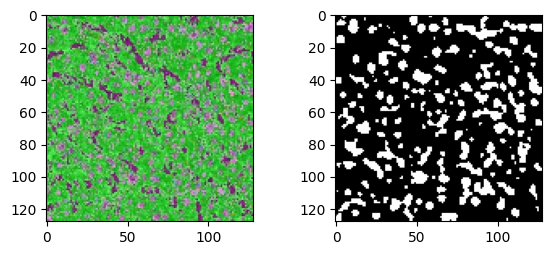

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
print(y[0])
ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(x[0], (image_size, image_size,3)))

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size,1)), cmap="gray")

In [ ]:
print(gen[0])

8
(array([[[[0.23921569, 0.8745098 , 0.23529412],
         [0.34901961, 0.9254902 , 0.36078431],
         [0.77647059, 0.76470588, 0.64313725],
         ...,
         [0.18823529, 0.81960784, 0.22745098],
         [0.13333333, 0.74901961, 0.14509804],
         [0.08627451, 0.71372549, 0.10196078]],

        [[0.32941176, 0.92941176, 0.32156863],
         [0.38431373, 0.79607843, 0.38039216],
         [0.50980392, 0.58431373, 0.39215686],
         ...,
         [0.1372549 , 0.76078431, 0.16862745],
         [0.1372549 , 0.72156863, 0.11764706],
         [0.23921569, 0.69411765, 0.10588235]],

        [[0.31372549, 0.89803922, 0.32156863],
         [0.12941176, 0.37254902, 0.1254902 ],
         [0.30588235, 0.64705882, 0.26666667],
         ...,
         [0.1254902 , 0.71372549, 0.10588235],
         [0.29411765, 0.72156863, 0.11764706],
         [0.37647059, 0.62352941, 0.15686275]],

        ...,

        [[0.63921569, 0.74509804, 0.64705882],
         [0.52941176, 0.78431373, 0.541176

In [ ]:
i=0
j=0
save_path='/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Hepatoma-Stages-Dataset/ADASYN_normalised/Non_cancerous_mask'
for i in range(0,27):
  #print(i)
  x,y= pred_gen.__getitem__(i)
  result = model.predict(x)
  result = result > 0.3
  for j in range(0,8):
    isWritten=cv2.imwrite(save_path+'/'+y[j],result[j]*255)
    if(isWritten):
      print('Wrote image: '+y[j])


8
0
1/1 [==============================] - 0s 336ms/step
Wrote image: f10.jpeg
Wrote image: f102.jpeg
Wrote image: f106.jpeg
Wrote image: f107.jpeg
Wrote image: f108.jpeg
Wrote image: f11.jpeg
Wrote image: f110.jpeg
Wrote image: f111.jpeg
8
1
1/1 [==============================] - 0s 340ms/step
Wrote image: f112.jpeg
Wrote image: f113.jpeg
Wrote image: f117.jpeg
Wrote image: f118.jpeg
Wrote image: f121.jpeg
Wrote image: f123.jpeg
Wrote image: f125.jpeg
Wrote image: f133.jpeg
8
2
1/1 [==============================] - 0s 357ms/step
Wrote image: f134.jpeg
Wrote image: f137.jpeg
Wrote image: f138.jpeg
Wrote image: f140.jpeg
Wrote image: f148.jpeg
Wrote image: f15.jpeg
Wrote image: f150.jpeg
Wrote image: f151.jpeg
8
3
1/1 [==============================] - 0s 330ms/step
Wrote image: f153.jpeg
Wrote image: f154.jpeg
Wrote image: f158.jpeg
Wrote image: f16.jpeg
Wrote image: f167.jpeg
Wrote image: f17.jpeg
Wrote image: f171.jpeg
Wrote image: f180.jpeg
8
4
1/1 [==============================] 

#Sanity Check

In [ ]:
sanity=[]
for i in os.listdir('/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Hepatoma-Stages-Dataset/ADASYN_normalised/Non_cancerous_mask'):
  sanity.append(i)
sanity=np.array(sanity)
print(len(np.unique(sanity)))

209


#Stage1

In [ ]:
image_path='/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Hepatoma-Stages-Dataset/ADASYN_normalised/Stage1'

In [ ]:
img_id=[]
for image in os.listdir(image_path):
  img_id.append(image)
  #print(img_id)
img_id.sort()
print(img_id)
print(len(img_id))

['f100.jpeg', 'f104.jpeg', 'f122.jpeg', 'f126.jpeg', 'f127.jpeg', 'f128.jpeg', 'f129.jpeg', 'f130.jpeg', 'f135.jpeg', 'f136.jpeg', 'f141.jpeg', 'f144.jpeg', 'f145.jpeg', 'f147.jpeg', 'f149.jpeg', 'f152.jpeg', 'f159.jpeg', 'f162.jpeg', 'f165.jpeg', 'f166.jpeg', 'f169.jpeg', 'f170.jpeg', 'f172.jpeg', 'f175.jpeg', 'f176.jpeg', 'f179.jpeg', 'f184.jpeg', 'f193.jpeg', 'f198.jpeg', 'f20.jpeg', 'f208.jpeg', 'f209.jpeg', 'f213.jpeg', 'f221.jpeg', 'f224.jpeg', 'f225.jpeg', 'f228.jpeg', 'f23.jpeg', 'f230.jpeg', 'f235.jpeg', 'f239.jpeg', 'f246.jpeg', 'f253.jpeg', 'f260.jpeg', 'f263.jpeg', 'f266.jpeg', 'f267.jpeg', 'f268.jpeg', 'f271.jpeg', 'f274.jpeg', 'f276.jpeg', 'f277.jpeg', 'f279.jpeg', 'f282.jpeg', 'f287.jpeg', 'f291.jpeg', 'f293.jpeg', 'f297.jpeg', 'f298.jpeg', 'f3.jpeg', 'f303.jpeg', 'f319.jpeg', 'f327.jpeg', 'f334.jpeg', 'f335.jpeg', 'f337.jpeg', 'f34.jpeg', 'f345.jpeg', 'f351.jpeg', 'f359.jpeg', 'f367.jpeg', 'f371.jpeg', 'f379.jpeg', 'f38.jpeg', 'f384.jpeg', 'f391.jpeg', 'f394.jpeg', 'f39

In [ ]:
class DataGenpredict(keras.utils.Sequence):
    def __init__(self, ids, batch_size=8, image_size=128):
        self.ids = ids
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()

    def __load__(self, id_name):
        ## Path
        image_path ='/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Hepatoma-Stages-Dataset/ADASYN_normalised/Stage1'+'/'+id_name


        ## Reading Image

        image = cv2.imread(image_path, 1)

        if(image is None):
          print("Error: ",id_name)
        image = cv2.resize(image, (self.image_size, self.image_size))

        #print(np.unique(mask))
        image = image/255.0

        #print(np.unique(mask))
        return image,id_name

    def __getitem__(self, index):
        # if(index+1)*self.batch_size > len(self.ids):
        #     self.batch_size = len(self.ids) - index*self.batch_size

        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        print(len(files_batch))
        if(len(files_batch)<self.batch_size):
          files_batch.extend(self.ids[0:self.batch_size-len(files_batch)])
        image = []
        ids=[]
        for i,id_name in enumerate(files_batch):
            while(not id_name.split('.')[1]=='jpeg'):
              id_name=files_batch[i+1]
              i+=1
              if(i>=self.batch_size):
                i=0
            _img,_id = self.__load__(id_name)
            image.append(_img)
            ids.append(_id)
        print(index)
        image = np.array(image)
        ids=np.array(ids)
        return image,ids

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [ ]:
gen = DataGenpredict(img_id, batch_size=batch_size, image_size=image_size)
for x,y in gen:
  print(x.shape)

8
0
(8, 128, 128, 3)
8
1
(8, 128, 128, 3)
8
2
(8, 128, 128, 3)
8
3
(8, 128, 128, 3)
8
4
(8, 128, 128, 3)
8
5
(8, 128, 128, 3)
8
6
(8, 128, 128, 3)
8
7
(8, 128, 128, 3)
8
8
(8, 128, 128, 3)
8
9
(8, 128, 128, 3)
8
10
(8, 128, 128, 3)
8
11
(8, 128, 128, 3)
8
12
(8, 128, 128, 3)
8
13
(8, 128, 128, 3)
8
14
(8, 128, 128, 3)
8
15
(8, 128, 128, 3)
8
16
(8, 128, 128, 3)
8
17
(8, 128, 128, 3)
8
18
(8, 128, 128, 3)
8
19
(8, 128, 128, 3)
8
20
(8, 128, 128, 3)
8
21
(8, 128, 128, 3)
8
22
(8, 128, 128, 3)
8
23
(8, 128, 128, 3)
8
24
(8, 128, 128, 3)
8
25
(8, 128, 128, 3)
8
26
(8, 128, 128, 3)
8
27
(8, 128, 128, 3)
8
28
(8, 128, 128, 3)
8
29
(8, 128, 128, 3)
8
30
(8, 128, 128, 3)
8
31
(8, 128, 128, 3)
2
32
(8, 128, 128, 3)


In [ ]:
pred_gen = DataGenpredict(img_id, image_size=image_size, batch_size=batch_size)

In [ ]:
i=0
j=0
save_path='/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Hepatoma-Stages-Dataset/ADASYN_normalised/Stage1_mask'
for i in range(0,33):
  #print(i)
  x,y= pred_gen.__getitem__(i)
  result = model.predict(x)
  result = result > 0.3
  for j in range(0,8):
    isWritten=cv2.imwrite(save_path+'/'+y[j],result[j]*255)
    if(isWritten):
      print('Wrote image: '+y[j])


8
0
1/1 [==============================] - 0s 337ms/step
Wrote image: f100.jpeg
Wrote image: f104.jpeg
Wrote image: f122.jpeg
Wrote image: f126.jpeg
Wrote image: f127.jpeg
Wrote image: f128.jpeg
Wrote image: f129.jpeg
Wrote image: f130.jpeg
8
1
1/1 [==============================] - 0s 341ms/step
Wrote image: f135.jpeg
Wrote image: f136.jpeg
Wrote image: f141.jpeg
Wrote image: f144.jpeg
Wrote image: f145.jpeg
Wrote image: f147.jpeg
Wrote image: f149.jpeg
Wrote image: f152.jpeg
8
2
1/1 [==============================] - 0s 335ms/step
Wrote image: f159.jpeg
Wrote image: f162.jpeg
Wrote image: f165.jpeg
Wrote image: f166.jpeg
Wrote image: f169.jpeg
Wrote image: f170.jpeg
Wrote image: f172.jpeg
Wrote image: f175.jpeg
8
3
1/1 [==============================] - 0s 343ms/step
Wrote image: f176.jpeg
Wrote image: f179.jpeg
Wrote image: f184.jpeg
Wrote image: f193.jpeg
Wrote image: f198.jpeg
Wrote image: f20.jpeg
Wrote image: f208.jpeg
Wrote image: f209.jpeg
8
4
1/1 [============================

#Sanity Check Stage 1

In [ ]:
sanity=[]
for i in os.listdir('/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Hepatoma-Stages-Dataset/ADASYN_normalised/Stage1_mask'):
  sanity.append(i)
sanity=np.array(sanity)
print(len(np.unique(sanity)))

258


#Stage 2

In [ ]:
image_path='/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Hepatoma-Stages-Dataset/ADASYN_normalised/Stage2'

In [ ]:
img_id=[]
for image in os.listdir(image_path):
  img_id.append(image)
  #print(img_id)
img_id.sort()
print(img_id)
print(len(img_id))

['f116.jpeg', 'f120.jpeg', 'f139.jpeg', 'f146.jpeg', 'f155.jpeg', 'f156.jpeg', 'f173.jpeg', 'f195.jpeg', 'f206.jpeg', 'f21.jpeg', 'f212.jpeg', 'f214.jpeg', 'f215.jpeg', 'f229.jpeg', 'f238.jpeg', 'f240.jpeg', 'f241.jpeg', 'f25.jpeg', 'f259.jpeg', 'f273.jpeg', 'f275.jpeg', 'f286.jpeg', 'f288.jpeg', 'f296.jpeg', 'f300.jpeg', 'f315.jpeg', 'f316.jpeg', 'f317.jpeg', 'f318.jpeg', 'f32.jpeg', 'f323.jpeg', 'f329.jpeg', 'f343.jpeg', 'f344.jpeg', 'f363.jpeg', 'f365.jpeg', 'f368.jpeg', 'f385.jpeg', 'f388.jpeg', 'f390.jpeg', 'f395.jpeg', 'f399.jpeg', 'f401.jpeg', 'f415.jpeg', 'f419.jpeg', 'f42.jpeg', 'f423.jpeg', 'f425.jpeg', 'f430.jpeg', 'f434.jpeg', 'f444.jpeg', 'f448.jpeg', 'f461.jpeg', 'f462.jpeg', 'f535.jpeg', 'f55.jpeg', 'f6.jpeg', 'f61.jpeg', 'f76.jpeg', 'f85.jpeg', 'f91.jpeg', 'f92.jpeg', 'f93.jpeg']
63


In [ ]:
class DataGenpredict(keras.utils.Sequence):
    def __init__(self, ids, batch_size=8, image_size=128):
        self.ids = ids
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()

    def __load__(self, id_name):
        ## Path
        image_path ='/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Hepatoma-Stages-Dataset/ADASYN_normalised/Stage2'+'/'+id_name


        ## Reading Image

        image = cv2.imread(image_path, 1)

        if(image is None):
          print("Error: ",id_name)
        image = cv2.resize(image, (self.image_size, self.image_size))

        #print(np.unique(mask))
        image = image/255.0

        #print(np.unique(mask))
        return image,id_name

    def __getitem__(self, index):
        # if(index+1)*self.batch_size > len(self.ids):
        #     self.batch_size = len(self.ids) - index*self.batch_size

        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        print(len(files_batch))
        if(len(files_batch)<self.batch_size):
          files_batch.extend(self.ids[0:self.batch_size-len(files_batch)])
        image = []
        ids=[]
        for i,id_name in enumerate(files_batch):
            while(not id_name.split('.')[1]=='jpeg'):
              id_name=files_batch[i+1]
              i+=1
              if(i>=self.batch_size):
                i=0
            _img,_id = self.__load__(id_name)
            image.append(_img)
            ids.append(_id)
        print(index)
        image = np.array(image)
        ids=np.array(ids)
        return image,ids

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [ ]:
gen = DataGenpredict(img_id, batch_size=batch_size, image_size=image_size)
for x,y in gen:
  print(x.shape)

8
0
(8, 128, 128, 3)
8
1
(8, 128, 128, 3)
8
2
(8, 128, 128, 3)
8
3
(8, 128, 128, 3)
8
4
(8, 128, 128, 3)
8
5
(8, 128, 128, 3)
8
6
(8, 128, 128, 3)
7
7
(8, 128, 128, 3)


In [ ]:
pred_gen = DataGenpredict(img_id, image_size=image_size, batch_size=batch_size)

In [ ]:
i=0
j=0
save_path='/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Hepatoma-Stages-Dataset/ADASYN_normalised/Stage2_mask'
for i in range(0,8):
  #print(i)
  x,y= pred_gen.__getitem__(i)
  result = model.predict(x)
  result = result > 0.3
  for j in range(0,8):
    isWritten=cv2.imwrite(save_path+'/'+y[j],result[j]*255)
    if(isWritten):
      print('Wrote image: '+y[j])


8
0
1/1 [==============================] - 0s 332ms/step
Wrote image: f116.jpeg
Wrote image: f120.jpeg
Wrote image: f139.jpeg
Wrote image: f146.jpeg
Wrote image: f155.jpeg
Wrote image: f156.jpeg
Wrote image: f173.jpeg
Wrote image: f195.jpeg
8
1
1/1 [==============================] - 0s 348ms/step
Wrote image: f206.jpeg
Wrote image: f21.jpeg
Wrote image: f212.jpeg
Wrote image: f214.jpeg
Wrote image: f215.jpeg
Wrote image: f229.jpeg
Wrote image: f238.jpeg
Wrote image: f240.jpeg
8
2
1/1 [==============================] - 0s 340ms/step
Wrote image: f241.jpeg
Wrote image: f25.jpeg
Wrote image: f259.jpeg
Wrote image: f273.jpeg
Wrote image: f275.jpeg
Wrote image: f286.jpeg
Wrote image: f288.jpeg
Wrote image: f296.jpeg
8
3
1/1 [==============================] - 0s 350ms/step
Wrote image: f300.jpeg
Wrote image: f315.jpeg
Wrote image: f316.jpeg
Wrote image: f317.jpeg
Wrote image: f318.jpeg
Wrote image: f32.jpeg
Wrote image: f323.jpeg
Wrote image: f329.jpeg
8
4
1/1 [==============================

#Sanity Check Stage2

In [ ]:
sanity=[]
for i in os.listdir('/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Hepatoma-Stages-Dataset/ADASYN_normalised/Stage2_mask'):
  sanity.append(i)
sanity=np.array(sanity)
print(len(np.unique(sanity)))

63


#Stage 3

In [ ]:
image_path='/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Hepatoma-Stages-Dataset/ADASYN_normalised/Stage3'

In [ ]:
img_id=[]
for image in os.listdir(image_path):
  img_id.append(image)
  #print(img_id)
img_id.sort()
print(img_id)
print(len(img_id))

['f0.jpeg', 'f1.jpeg', 'f101.jpeg', 'f103.jpeg', 'f105.jpeg', 'f109.jpeg', 'f114.jpeg', 'f115.jpeg', 'f119.jpeg', 'f12.jpeg', 'f124.jpeg', 'f13.jpeg', 'f131.jpeg', 'f132.jpeg', 'f14.jpeg', 'f142.jpeg', 'f143.jpeg', 'f157.jpeg', 'f160.jpeg', 'f161.jpeg', 'f163.jpeg', 'f164.jpeg', 'f168.jpeg', 'f174.jpeg', 'f177.jpeg', 'f178.jpeg', 'f18.jpeg', 'f182.jpeg', 'f183.jpeg', 'f186.jpeg', 'f187.jpeg', 'f189.jpeg', 'f196.jpeg', 'f197.jpeg', 'f199.jpeg', 'f203.jpeg', 'f218.jpeg', 'f219.jpeg', 'f220.jpeg', 'f222.jpeg', 'f231.jpeg', 'f234.jpeg', 'f237.jpeg', 'f243.jpeg', 'f248.jpeg', 'f251.jpeg', 'f252.jpeg', 'f254.jpeg', 'f26.jpeg', 'f262.jpeg', 'f264.jpeg', 'f269.jpeg', 'f27.jpeg', 'f278.jpeg', 'f280.jpeg', 'f281.jpeg', 'f285.jpeg', 'f289.jpeg', 'f292.jpeg', 'f295.jpeg', 'f299.jpeg', 'f301.jpeg', 'f304.jpeg', 'f306.jpeg', 'f308.jpeg', 'f310.jpeg', 'f312.jpeg', 'f313.jpeg', 'f320.jpeg', 'f321.jpeg', 'f322.jpeg', 'f324.jpeg', 'f325.jpeg', 'f326.jpeg', 'f33.jpeg', 'f331.jpeg', 'f338.jpeg', 'f339.jpe

In [ ]:
class DataGenpredict(keras.utils.Sequence):
    def __init__(self, ids, batch_size=8, image_size=128):
        self.ids = ids
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()

    def __load__(self, id_name):
        ## Path
        image_path ='/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Hepatoma-Stages-Dataset/ADASYN_normalised/Stage3'+'/'+id_name


        ## Reading Image

        image = cv2.imread(image_path, 1)

        if(image is None):
          print("Error: ",id_name)
        image = cv2.resize(image, (self.image_size, self.image_size))

        #print(np.unique(mask))
        image = image/255.0

        #print(np.unique(mask))
        return image,id_name

    def __getitem__(self, index):
        # if(index+1)*self.batch_size > len(self.ids):
        #     self.batch_size = len(self.ids) - index*self.batch_size

        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        print(len(files_batch))
        if(len(files_batch)<self.batch_size):
          files_batch.extend(self.ids[0:self.batch_size-len(files_batch)])
        image = []
        ids=[]
        for i,id_name in enumerate(files_batch):
            while(not id_name.split('.')[1]=='jpeg'):
              id_name=files_batch[i+1]
              i+=1
              if(i>=self.batch_size):
                i=0
            _img,_id = self.__load__(id_name)
            image.append(_img)
            ids.append(_id)
        print(index)
        image = np.array(image)
        ids=np.array(ids)
        return image,ids

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [ ]:
gen = DataGenpredict(img_id, batch_size=batch_size, image_size=image_size)
for x,y in gen:
  print(x.shape)

8
0
(8, 128, 128, 3)
8
1
(8, 128, 128, 3)
8
2
(8, 128, 128, 3)
8
3
(8, 128, 128, 3)
8
4
(8, 128, 128, 3)
8
5
(8, 128, 128, 3)
8
6
(8, 128, 128, 3)
8
7
(8, 128, 128, 3)
8
8
(8, 128, 128, 3)
8
9
(8, 128, 128, 3)
8
10
(8, 128, 128, 3)
8
11
(8, 128, 128, 3)
8
12
(8, 128, 128, 3)
8
13
(8, 128, 128, 3)
8
14
(8, 128, 128, 3)
8
15
(8, 128, 128, 3)
8
16
(8, 128, 128, 3)
8
17
(8, 128, 128, 3)
8
18
(8, 128, 128, 3)
1
19
(8, 128, 128, 3)


In [ ]:
pred_gen = DataGenpredict(img_id, image_size=image_size, batch_size=batch_size)

In [ ]:
i=0
j=0
save_path='/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Hepatoma-Stages-Dataset/ADASYN_normalised/Stage3_mask'
for i in range(0,20):
  #print(i)
  x,y= pred_gen.__getitem__(i)
  result = model.predict(x)
  result = result > 0.3
  for j in range(0,8):
    isWritten=cv2.imwrite(save_path+'/'+y[j],result[j]*255)
    if(isWritten):
      print('Wrote image: '+y[j])


8
0
1/1 [==============================] - 0s 339ms/step
Wrote image: f0.jpeg
Wrote image: f1.jpeg
Wrote image: f101.jpeg
Wrote image: f103.jpeg
Wrote image: f105.jpeg
Wrote image: f109.jpeg
Wrote image: f114.jpeg
Wrote image: f115.jpeg
8
1
1/1 [==============================] - 1s 614ms/step
Wrote image: f119.jpeg
Wrote image: f12.jpeg
Wrote image: f124.jpeg
Wrote image: f13.jpeg
Wrote image: f131.jpeg
Wrote image: f132.jpeg
Wrote image: f14.jpeg
Wrote image: f142.jpeg
8
2
1/1 [==============================] - 1s 652ms/step
Wrote image: f143.jpeg
Wrote image: f157.jpeg
Wrote image: f160.jpeg
Wrote image: f161.jpeg
Wrote image: f163.jpeg
Wrote image: f164.jpeg
Wrote image: f168.jpeg
Wrote image: f174.jpeg
8
3
1/1 [==============================] - 1s 667ms/step
Wrote image: f177.jpeg
Wrote image: f178.jpeg
Wrote image: f18.jpeg
Wrote image: f182.jpeg
Wrote image: f183.jpeg
Wrote image: f186.jpeg
Wrote image: f187.jpeg
Wrote image: f189.jpeg
8
4
1/1 [==============================] - 1

#Sanity Check Stage3

In [ ]:
sanity=[]
for i in os.listdir('/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Hepatoma-Stages-Dataset/ADASYN_normalised/Stage3_mask'):
  sanity.append(i)
sanity=np.array(sanity)
print(len(np.unique(sanity)))

153
